In [1]:
from gpt.gpt_distgen import run_gpt_with_distgen, evaluate_gpt_with_distgen
from gpt import GPT
import yaml
import numpy as np

def test_cu_injector_template(test_dataset1='gpt356_apple_silicon', 
                              test_dataset2=None,
                              check_particles=True,
                              check_stats=True,
                              check_eval=True):

    settings={'n_particle':100, 
          #'final_n_particle':200,
          'r_dist:sigma_xy:value':3,
          'Ntout':100,
          'gun_voltage':400,
          'buncher_voltage':50,
          'phiCTB01_off':-90, 
          'cavity_1_voltage':1000,
          'cavity_2_voltage':1000,
          'cavity_3_voltage':1000,
          'cavity_4_voltage':1000,
          'cavity_5_voltage':1000,
          'A3Quad_1_current':3,
          'A3Quad_2_current':-3,
          'A3Quad_3_current':3
         }

    if test_dataset2 is None:
        G2 = run_gpt_with_distgen(settings,
                                  gpt_input_file='../examples/templates/cu_injector/gpt.in',
                                  distgen_input_file='../examples/templates/cu_injector/distgen.in.yaml',
                                  verbose=True,
                                  auto_phase=True,
                                  parse_layout=False)
                             #workdir='templates/cu_injector/temp',
                             #use_tempdir=False)
    else:

        G2 = GPT()
        G2.load_archive(f'../examples/templates/cu_injector/test.{test_dataset2}.h5')

    G1 = GPT()
    G1.load_archive(f'../examples/templates/cu_injector/test.{test_dataset1}.h5')

    assert G2.n_screen == G1.n_screen, 'Inconsistent number of screens'
    assert G2.n_tout == G1.n_tout, 'Inconsistent number of touts'

    keys = ['x', 'y', 'z', 'px', 'pz', 'py', 't', 'id']

    if check_particles:
        for ii, scr in enumerate(G2.screen):
    
            for key in keys:
                assert np.all(np.isclose(scr[key], G1.screen[ii][key], equal_nan=True, rtol=5e-02, atol=5)), f'{key}: max error = {100*np.max(np.abs(scr[key]-G1.screen[ii][key])/np.abs(G1.screen[ii][key]))} %'
    
        for ii, tout in enumerate(G2.tout):
    
            for key in keys:
                assert np.all(np.isclose(tout[key], G1.tout[ii][key])), f'{key}'

    

    if check_stats:
        print('\nCheck Stats:')
        print('======================================')
        for stype in ['mean', 'sigma']:

            for key in keys:
                skey = f'{stype}_{key}'

                stat1, stat2 = G1.tout_stat(f'{stype}_{key}'), G2.tout_stat(f'{stype}_{key}')
                assert np.all(np.isclose(stat1, stat2, equal_nan=True, rtol=5e-02, atol=5)), f'{key}: max error = {100*np.max(np.abs(stat2 - stat1)/np.abs(stat1))}' 
                print('tout', skey, 'checks')

            for key in keys:
                skey = f'{stype}_{key}'

                stat1, stat2 = G1.screen_stat(f'{stype}_{key}'), G2.screen_stat(f'{stype}_{key}')
                assert np.all(np.isclose(stat1, stat2, equal_nan=True, rtol=5e-02, atol=5)), f'{key}: max error = {100*np.max(np.abs(stat2 - stat1)/np.abs(stat1))}' 
                print('screen', skey, 'checks')

        print('======================================\n')
    if check_eval:

        with open(f'../examples/templates/cu_injector/eval.test.{test_dataset1}.yaml', 'r') as fid:
            res1 = yaml.safe_load(fid)
        
        res2 = evaluate_gpt_with_distgen(settings=settings,
                                         gpt_input_file='../examples/templates/cu_injector/gpt.in',
                                         distgen_input_file='../examples/templates/cu_injector/distgen.in.yaml',
                                         verbose=True,
                                         auto_phase=True,
                                         parse_layout=False
                                        )

    
        print('\nCheck eval')
        print('======================================')
        for k in res2:
            if isinstance(res2[k], float):
                assert np.isclose(res2[k] ,res1[k]), f'Bad eval merit: {k} ({100*(res2[k]-res1[k])/res1[k]} %)' 
                print(k, 'checks')




In [2]:
test_cu_injector_template(test_dataset1='gpt356_apple_silicon', check_particles=False)

Run GPT with Distgen:
n_particle is in distgen
Replacing param n_particle with value 100
r_dist:sigma_xy:value is in distgen
Replacing param r_dist:sigma_xy:value with value 3
Ntout is in gpt
gun_voltage is in gpt
buncher_voltage is in gpt
phiCTB01_off is in gpt
cavity_1_voltage is in gpt
cavity_2_voltage is in gpt
cavity_3_voltage is in gpt
cavity_4_voltage is in gpt
cavity_5_voltage is in gpt
A3Quad_1_current is in gpt
A3Quad_2_current is in gpt
A3Quad_3_current is in gpt
Linking particle files, distgen output will point to -> "gpt_particles.gdf" in working directory.
Replacing Distgen output params

Distgen >------

Distribution format: gpt
Output file: /var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/tmpgu5egpwv/gpt_particles.gdf

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 1 nC.
   Number of macroparticles: 100.
   Assuming cylindrical symmetry...
   r distribution: SuperGaussianRad
      lambda = 4.24264 mm, power = INF
   theta distribution: un

# Comparison of GPT v3.5.6 to GPT v3.5.3
---

In [3]:
from matplotlib import pyplot as plt

G1 = GPT()
G1.load_archive('../examples/templates/cu_injector/test.gpt353_apple_silicon.h5')

In [4]:
G2 = GPT()
G2.load_archive('../examples/templates/cu_injector/test.gpt356_apple_silicon.h5')

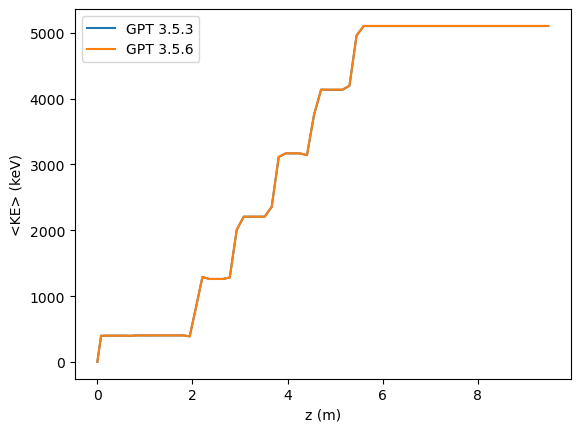

In [5]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('mean_kinetic_energy')/1000, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_kinetic_energy')/1000, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'<KE> (keV)')
plt.legend()

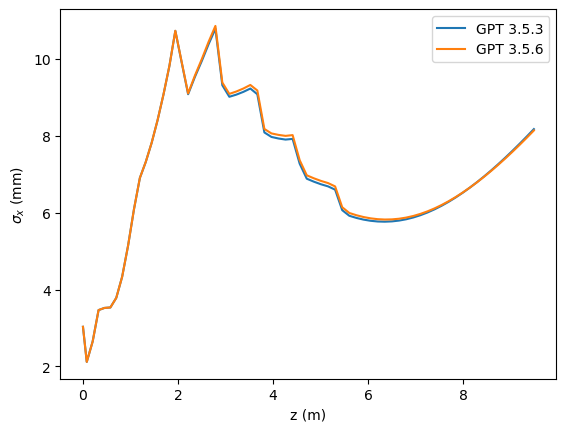

In [6]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('sigma_x')*1000, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('sigma_x')*1000, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_x$ (mm)')
plt.legend()

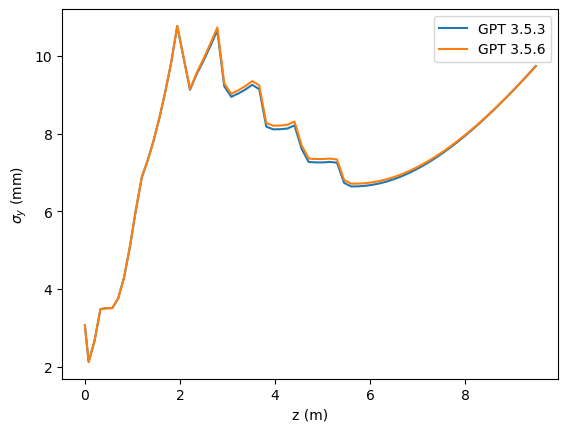

In [7]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('sigma_y')*1000, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('sigma_y')*1000, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_y$ (mm)')
plt.legend()

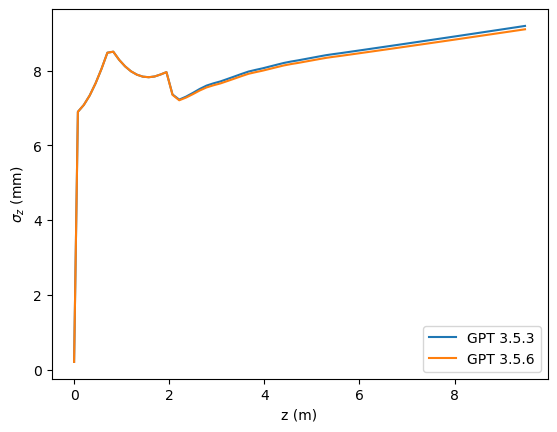

In [8]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('sigma_z')*1e3, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('sigma_z')*1e3, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_z$ (mm)')
plt.legend()

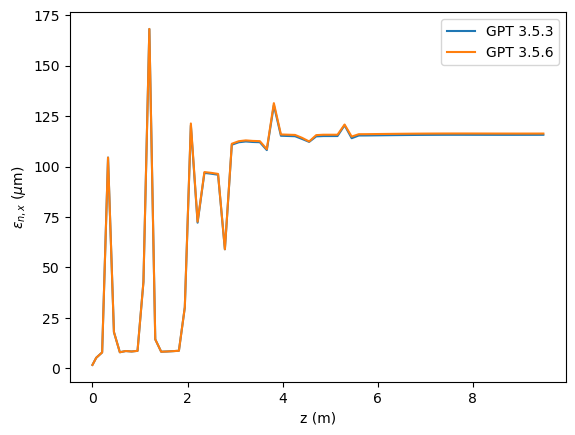

In [9]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('norm_emit_x')*1e6, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('norm_emit_x')*1e6, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\epsilon_{n,x}$ ($\mu$m)')
plt.legend()

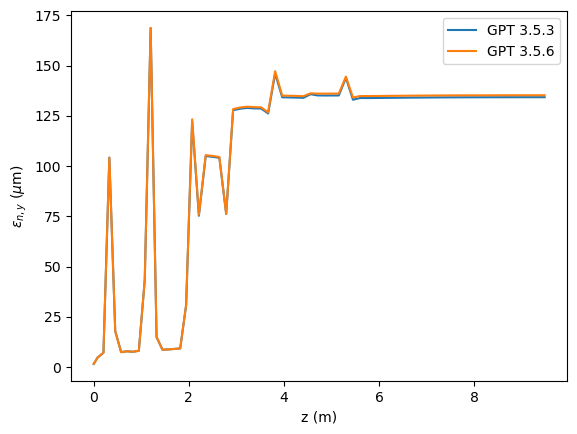

In [10]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('norm_emit_y')*1e6, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('norm_emit_y')*1e6, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\epsilon_{n,y}$ ($\mu$m)')
plt.legend()

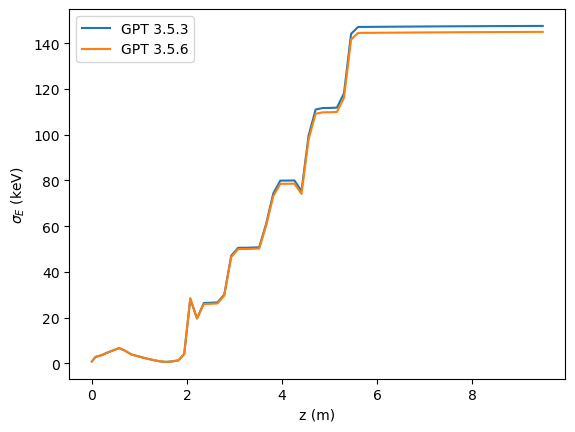

In [11]:
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('sigma_energy')/1e3, label='GPT 3.5.3')
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('sigma_energy')/1e3, label='GPT 3.5.6')
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_E$ (keV)')
plt.legend()